## Abordagem Quantitativa da fronteira de eficiência de portifílio

#### Bibliotecas Necessárias

In [50]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#### Etapa 1: Coleta e Processamento de Dados

In [51]:
ATIVOS = ['ITSA4.SA', 'PETR4.SA', 'VALE3.SA', 'BBDC4.SA', 'WEGE3.SA']
DATA_INICIO = "2020-01-01"
DATA_FIM = "2026-01-01"
DIAS_UTEIS_ANO = 252

raw = yf.download(ATIVOS, start=DATA_INICIO, end=DATA_FIM, progress=False)

if raw.empty:
    raise ValueError("Download retornou vazio. Verifique tickers, conexão e período.")

# 'Adj Close' nem sempre vem em alguns casos; tenta fallback para 'Close'
col = "Adj Close" if "Adj Close" in raw.columns.get_level_values(0) else "Close"
dados = raw[col].copy()

# Remove colunas 100% NaN (ticker que falhou)
dados = dados.dropna(axis=1, how="all")

if dados.shape[1] == 0:
    raise ValueError("Nenhum ticker retornou dados válidos (todas colunas NaN).")

faltaram = sorted(set(ATIVOS) - set(dados.columns))
if faltaram:
    print("Tickers sem dados (removidos):", faltaram)

retornos = dados.pct_change().dropna()*100  # em %

retornos_medios_anuais = retornos.mean() * DIAS_UTEIS_ANO
matriz_covariancia = retornos.cov() * DIAS_UTEIS_ANO

print(retornos_medios_anuais, '\n')
print(matriz_covariancia)


Ticker
BBDC4.SA     5.470387
ITSA4.SA    12.390254
PETR4.SA    30.108298
VALE3.SA    20.904142
WEGE3.SA    26.035158
dtype: float64 

Ticker       BBDC4.SA    ITSA4.SA     PETR4.SA     VALE3.SA     WEGE3.SA
Ticker                                                                  
BBDC4.SA  1293.245479  784.440303   742.345505   476.268120   332.945630
ITSA4.SA   784.440303  742.755901   582.602697   365.358685   331.000183
PETR4.SA   742.345505  582.602697  1741.988150   673.605602   470.613655
VALE3.SA   476.268120  365.358685   673.605602  1255.227038   323.632183
WEGE3.SA   332.945630  331.000183   470.613655   323.632183  1359.570177


#### Etapa 2: Funções de Cálculo das Métricas

In [52]:
def calcular_metricas_portfolio(pesos, retornos_medios_anuais, matriz_covariancia):
    """
    Calcula retorno, volatilidade e Sharpe Ratio de um portfólio.
    
    Parâmetros:
        pesos: array numpy com os pesos de cada ativo
        retornos_medios_anuais: série pandas com retornos esperados
        matriz_covariancia: matriz de covariância dos retornos
    
    Retorna:
        array [retorno, volatilidade, sharpe_ratio]
    """
    pesos = np.array(pesos)
    
    # Retorno do portfólio: Rp = Σ(Wi × Ri)
    retorno_portfolio = np.sum(retornos_medios_anuais * pesos)
    
    # Volatilidade: σp = √(W^T × Σ × W)
    volatilidade_portfolio = np.sqrt(np.dot(pesos.T, np.dot(matriz_covariancia, pesos)))
    
    # Sharpe Ratio (assumindo taxa livre de risco = 0) <- MELHORIA usar dado real do CDI
    sharpe_ratio = retorno_portfolio / volatilidade_portfolio
    
    return np.array([retorno_portfolio, volatilidade_portfolio, sharpe_ratio])


#### Etapa 3: Funções Objetivo para Otimização

In [53]:
def minimizar_volatilidade(pesos, retornos_medios_anuais, matriz_covariancia):
    """
    Função objetivo para encontrar o portfólio de Mínima Variância.
    Retorna apenas a volatilidade (índice 1).
    """
    return calcular_metricas_portfolio(pesos, retornos_medios_anuais, matriz_covariancia)[1]

def maximizar_sharpe(pesos, retornos_medios_anuais, matriz_covariancia):
    """
    Função objetivo para encontrar o portfólio de Sharpe Máximo.
    Como minimize() busca o mínimo, retornamos o Sharpe negativo.
    """
    return -calcular_metricas_portfolio(pesos, retornos_medios_anuais, matriz_covariancia)[2]


#### Etapa 4: Configuração da Otimização

In [54]:
# Parâmetros
num_ativos = len(ATIVOS)
pesos_iniciais = np.array([1.0/num_ativos] * num_ativos)  # Distribuição igual

# Restrições
limites = tuple((0, 1) for _ in range(num_ativos))  # Cada peso entre 0% e 100%
restricoes = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Soma = 1

# Otimização para Carteira de Mínima Variância
otimizacao_min_vol = minimize(
    minimizar_volatilidade,
    pesos_iniciais,
    args=(retornos_medios_anuais, matriz_covariancia),
    method='SLSQP',  # Sequential Least Squares Programming
    bounds=limites,
    constraints=restricoes
)

pesos_min_vol = otimizacao_min_vol.x
metricas_min_vol = calcular_metricas_portfolio(pesos_min_vol, retornos_medios_anuais, matriz_covariancia)

# Otimização para Portfólio de Sharpe Máximo
otimizacao_max_sharpe = minimize(
    maximizar_sharpe,
    pesos_iniciais,
    args=(retornos_medios_anuais, matriz_covariancia),
    method='SLSQP',
    bounds=limites,
    constraints=restricoes
)

pesos_max_sharpe = otimizacao_max_sharpe.x
metricas_max_sharpe = calcular_metricas_portfolio(pesos_max_sharpe, retornos_medios_anuais, matriz_covariancia)


#### Etapa 5: Simulação de Monte Carlo para Visualizar a Fronteira

In [55]:
# Simulação de 100.000 portfólios aleatórios
num_portfolios = 100000
resultados = np.zeros((3, num_portfolios))  # [retorno, risco, sharpe]

np.random.seed(42)  # Para reprodutibilidade

for i in range(num_portfolios):
    # Gerar pesos aleatórios
    pesos_aleatorios = np.random.random(num_ativos)
    pesos_aleatorios /= np.sum(pesos_aleatorios)  # Normalizar para somar 1
    
    # Calcular métricas
    metricas = calcular_metricas_portfolio(pesos_aleatorios, retornos_medios_anuais, matriz_covariancia)
    resultados[0, i] = metricas[0]  # retorno
    resultados[1, i] = metricas[1]  # risco
    resultados[2, i] = metricas[2]  # sharpe


#### Etapa 6: Visualização da Fronteira Eficiente

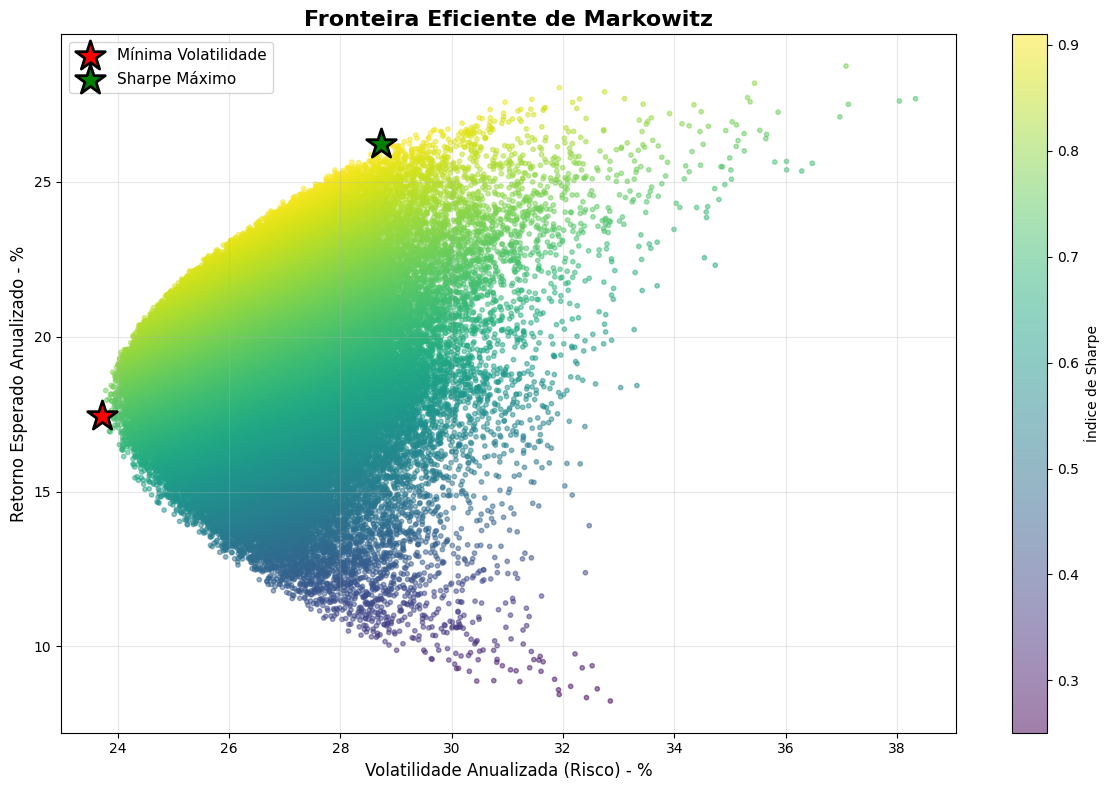

In [56]:
# Criar gráfico
plt.figure(figsize=(12, 8))

# Nuvem de portfólios aleatórios (coloridos pelo Sharpe Ratio)
scatter = plt.scatter(
    resultados[1, :],  # Volatilidade (eixo X)
    resultados[0, :],  # Retorno (eixo Y)
    c=resultados[2, :],  # Cor baseada no Sharpe
    cmap='viridis',
    marker='o',
    s=10,
    alpha=0.5
)
plt.colorbar(scatter, label='Índice de Sharpe')

# Destacar Carteira de Mínima Variância
plt.scatter(
    metricas_min_vol[1], 
    metricas_min_vol[0], 
    marker='*', 
    color='red', 
    s=500, 
    label='Mínima Volatilidade',
    edgecolors='black',
    linewidths=2
)

# Destacar Portfólio de Sharpe Máximo
plt.scatter(
    metricas_max_sharpe[1], 
    metricas_max_sharpe[0], 
    marker='*', 
    color='green', 
    s=500, 
    label='Sharpe Máximo',
    edgecolors='black',
    linewidths=2
)

# Formatação
plt.title('Fronteira Eficiente de Markowitz', fontsize=16, fontweight='bold')
plt.xlabel('Volatilidade Anualizada (Risco) - %', fontsize=12)
plt.ylabel('Retorno Esperado Anualizado - %', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
